##Install Modules

In [ ]:
#General modules
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, pathlib
import tensorflow_datasets as tfds
import cv2
import random

#Load the directory
from skimage.transform import resize
from skimage.io import imread

#Train & test the baseline model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

##Load the Directory

In [ ]:
#Connect to the directory
plasticimagedir = '/content/drive/MyDrive/Plastic_images_dir'
os.chdir(plasticimagedir)
!ls

augmented_classifier.png  LDPE		      PVC
checkpoint_path2.keras	  model_ensemble.pkl  saved_model
checkpoint_path.keras	  OTHER		      simple_classifier.png
cnn_classifier.png	  PET
HDPE			  PP


## Pre-Process the Data

In [ ]:
#Categories of plastic types 
Categories=['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC']

#Image size
IMG_SIZE = 64

In [ ]:
#Code adapted from the following sources:
#1. https://www.kaggle.com/code/ashutoshvarma/image-classification-using-svm-92-accuracy
#2. https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01

dataset_arr=[] #input array

#Loop through the categories
for i in Categories:
    print(f'loading... {i}') #display message to show that category is loading
    path=os.path.join(plasticimagedir,i) #join to the image directory
    class_index=Categories.index(i) #subdirectory name which is the inferred label
    class_len=len(os.listdir(path)) #get the number of files per category

    for img in os.listdir(path):
        try:
          img_array=cv2.imread(os.path.join(path,img))
          resized_array=cv2.resize(img_array,(IMG_SIZE, IMG_SIZE)) #resize images
          dataset_arr.append([resized_array,class_index])
        except Exception as e:
          pass
    print(f'loaded {i} successfully:', class_len) #display message to show that category has been loaded successfully

loading... HDPE
loaded HDPE successfully: 520
loading... LDPE
loaded LDPE successfully: 516
loading... OTHER
loaded OTHER successfully: 502
loading... PET
loaded PET successfully: 544
loading... PP
loaded PP successfully: 573
loading... PVC
loaded PVC successfully: 540


In [ ]:
#Shuffle the dataset array
random.shuffle(dataset_arr)

In [ ]:
lenofimage = len(dataset_arr)

X=[] #array to store the image data
y=[] #array to store the labels

#loop through the dataset array, and save the image data and labels into separate arrays
#remember in the intial for loop, we saved both the resized array and labels into the dataset array
for imgdata, label in dataset_arr:
    X.append(imgdata)
    y.append(label)

#Reshape the array - X should now be a Rank-2 tensor (matrix) 
# sklearn expects a 2D array as input to the fit() function which will be called on the model during training., the second being height*width*channels
X= np.array(X).reshape(lenofimage,-1)

#Normalise the array - maintain the pixels of all the images within a uniform range.
X = X/255.0
print(X.shape)

#Y should now be a Rank-1 tensor (vector) as it is just the name of the label
y=np.array(y)
print(y.shape)

(3195, 12288)
(3195,)


## Decision Trees

###Hyperparameter Tuning

In [ ]:
#Guidance from: https://scikit-learn.org/stable/modules/tree.html
#Split the data
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=77)

In [ ]:
#Create a decision tree classifier
treeclf = tree.DecisionTreeClassifier(random_state = 77)

In [ ]:
#Create a model through RandomizedCV and the parameters grid
param_grid={'max_leaf_nodes': list(range(2, 200))}
model=RandomizedSearchCV(treeclf,param_grid, random_state=0,n_jobs=-1, cv=3)
#Fit the data - 4 minutes (when image was 150 and range was 2:50 time was 19 minutes)
model.fit(x_train, y_train)
model.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=73, random_state=77)

In [ ]:
#Create a model through RandomizedCV and the parameters grid
param_grid_2={'min_samples_split': list(range(2, 200))}
model_2=RandomizedSearchCV(treeclf,param_grid_2, random_state=0,n_jobs=-1, cv=3)
#Fit the data - 4 minutes (when image was 150 and range was 2:50 time was 24 minutes)
model_2.fit(x_train, y_train)
model_2.best_estimator_

DecisionTreeClassifier(min_samples_split=73, random_state=77)

In [ ]:
#Create a model through RandomizedCV and the parameters grid
param_grid_3={'max_depth': list(range(2, 200))}
model_3=RandomizedSearchCV(treeclf,param_grid_3, random_state=0,n_jobs=-1, cv=3)
#Fit the data - 5 minutes (when image was 150 and range was 2:50 time was 28 minutes)
model_3.fit(x_train, y_train)
model_3.best_estimator_

DecisionTreeClassifier(max_depth=7, random_state=77)

In [ ]:
#Create a model through RandomizedCV and the parameters grid
param_grid_4={'min_samples_leaf': list(range(2, 200))}
model_4=RandomizedSearchCV(treeclf,param_grid_4, random_state=0,n_jobs=-1, cv=3)
#Fit the data - 2 minutes (when image was 150 and range was 2:50 time was 19 minutes)
model_4.fit(x_train, y_train)
model_4.best_estimator_

DecisionTreeClassifier(min_samples_leaf=14, random_state=77)

###Training and Testing the Model

In [ ]:
#Train the data using Decision Trees
clf = tree.DecisionTreeClassifier(max_leaf_nodes = 73, random_state = 77, min_samples_split = 73, min_samples_leaf=14, max_depth=7,
                                  criterion="entropy", splitter="best")

#Fit the data
clf.fit(x_train, y_train)

#Test the dataset using the RandomForestClassifier
y_pred = clf.predict(x_test)

#print the metrics to give a baseline score
print('Training score:', clf.score(x_train, y_train))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred, average = 'weighted'))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('F1_score:', f1_score(y_test, y_pred, average = 'macro'))

Training score: 0.6048513302034428
Accuracy: 0.4475743348982786
Recall: 0.4475743348982786
Precision: 0.4475743348982786
F1_score: 0.44546293132212317


In [ ]:
#print the classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.51      0.36      0.42       141
           1       0.48      0.47      0.47       131
           2       0.49      0.53      0.51        93
           3       0.30      0.45      0.36        64
           4       0.48      0.57      0.52        94
           5       0.41      0.36      0.38       116

    accuracy                           0.45       639
   macro avg       0.45      0.46      0.45       639
weighted avg       0.46      0.45      0.45       639



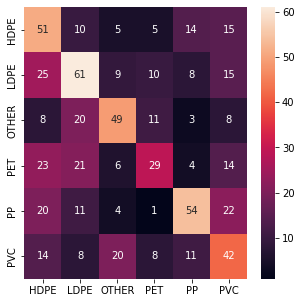

In [ ]:
#print the confusion matrix as an image
confmat = confusion_matrix(y_test, y_pred)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat = pd.DataFrame(confmat, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot = sns.heatmap(df_confmat, annot=True)

##Random Forest Classifier

###Hyperparameter Tuning

In [ ]:
#Guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
forestclf = RandomForestClassifier(random_state = 0)

In [ ]:
#Create a model through RandomizedCV and the parameters grid
param_grid_5={'n_estimators': list(range(2, 200))}
model_5=RandomizedSearchCV(forestclf,param_grid_5, random_state=0,n_jobs=-1, cv=5)
#Fit the data - 2 minutes
model_5.fit(x_train, y_train)
model_5.best_estimator_

RandomForestClassifier(n_estimators=170, random_state=77)

In [ ]:
#Create a model through RandomizedCV and the parameters grid
param_grid_6={'min_samples_split': list(range(2, 200))}
model_6=RandomizedSearchCV(forestclf,param_grid_6, random_state=0,n_jobs=-1, cv=5)
#Fit the data - 7 minutes
model_6.fit(x_train, y_train)
model_6.best_estimator_

RandomForestClassifier(min_samples_split=7, random_state=77)

In [ ]:
#Create a model through RandomizedCV and the parameters grid
param_grid_7={'min_samples_leaf': list(range(2, 200))}
model_7=RandomizedSearchCV(forestclf,param_grid_7, random_state=0,n_jobs=-1, cv=5)
#Fit the data - 4 minutes
model_7.fit(x_train, y_train)
model_7.best_estimator_

RandomForestClassifier(min_samples_leaf=7, random_state=77)

In [ ]:
#Create a model through RandomizedCV and the parameters grid
param_grid_8={'max_features': list(range(2, 200))}
model_8=RandomizedSearchCV(forestclf,param_grid_8, random_state=0,n_jobs=-1, cv=5)
#Fit the data - 1 minutes
model_8.fit(x_train, y_train)
model_8.best_estimator_

RandomForestClassifier(max_features=120, random_state=77)

In [ ]:
#Create a model through RandomizedCV and the parameters grid
param_grid_9={'max_features': list(range(2, 200)), 
              'n_estimators': list(range(2, 200)),
              'min_samples_split': list(range(2, 200)),
              'min_samples_leaf': list(range(2, 200)),
              'max_depth': list(range(2, 200)),
              'criterion': ('gini', 'entropy', 'log_loss')}
model_9=RandomizedSearchCV(forestclf,param_grid_9, random_state=0,n_jobs=-1, cv=5)
#Fit the data - 1 minutes
model_9.fit(x_train, y_train)
model_9.best_estimator_

RandomForestClassifier(max_depth=61, max_features=152, min_samples_leaf=17,
                       min_samples_split=51, n_estimators=178, random_state=0)

### Training and Testing the Model

In [ ]:
#Train the data using RandomForestClassifier
#clf2 = RandomForestClassifier(max_depth = 7, random_state = 77, criterion = "entropy", 
                              #min_samples_split = 20, min_samples_leaf = 6)
#clf2 = RandomForestClassifier(random_state = 77, n_estimators = 100, criterion = "entropy",
                              #min_samples_split = 2, min_samples_leaf = 1, max_features = "sqrt") - 66%
#clf2 = RandomForestClassifier(random_state = 77, n_estimators = 42, min_samples_split = 6, criterion="entropy",
                              #min_samples_leaf = 9, max_features = "sqrt") - 63%
clf2 = RandomForestClassifier(random_state = 0, n_estimators = 170, min_samples_split = 7, criterion="entropy",
                              min_samples_leaf = 7, max_features = "sqrt")

#Fit the data
clf2.fit(x_train, y_train)

#Test the dataset using the RandomForestClassifier
y_pred2 = clf2.predict(x_test)

#print the metrics to give a baseline score
print('Training score:', clf2.score(x_train, y_train))
print('Accuracy:', accuracy_score(y_test, y_pred2))
print('Recall:', recall_score(y_test, y_pred2, average = 'weighted'))
print('Precision:', precision_score(y_test, y_pred2, average='micro'))
print('F1_score:', f1_score(y_test, y_pred2, average = 'macro'))

Training score: 0.9671361502347418
Accuracy: 0.6494522691705791
Recall: 0.6494522691705791
Precision: 0.6494522691705791
F1_score: 0.6437729323997843


In [ ]:
#print the classification report
print(classification_report(y_pred2,y_test))

              precision    recall  f1-score   support

           0       0.51      0.59      0.55        86
           1       0.65      0.66      0.66       125
           2       0.71      0.74      0.72        95
           3       0.52      0.53      0.52        94
           4       0.81      0.68      0.74       134
           5       0.68      0.67      0.67       105

    accuracy                           0.65       639
   macro avg       0.65      0.65      0.64       639
weighted avg       0.66      0.65      0.65       639



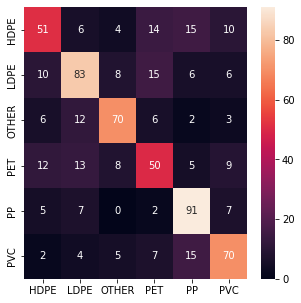

In [ ]:
#print the confusion matrix as an image
confmat2 = confusion_matrix(y_test, y_pred2)

#put the confusion matrix into a dataframe
df_confmat2 = pd.DataFrame(confmat2, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot_2 = sns.heatmap(df_confmat2, annot=True)

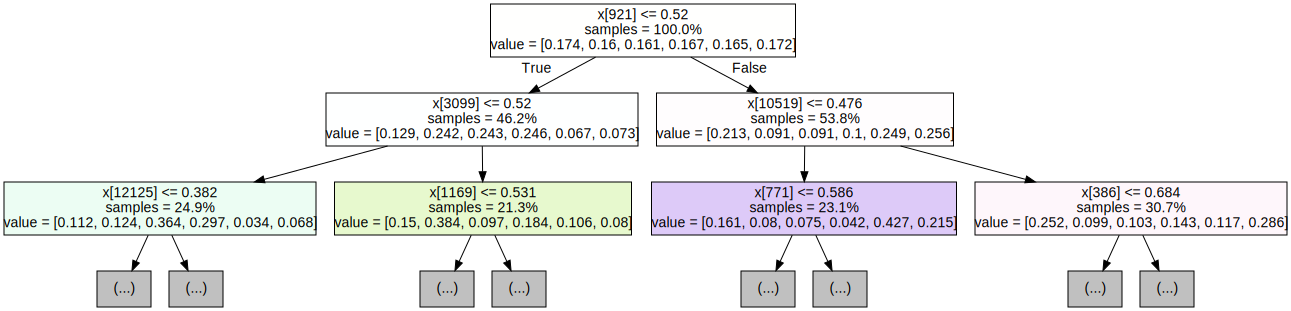

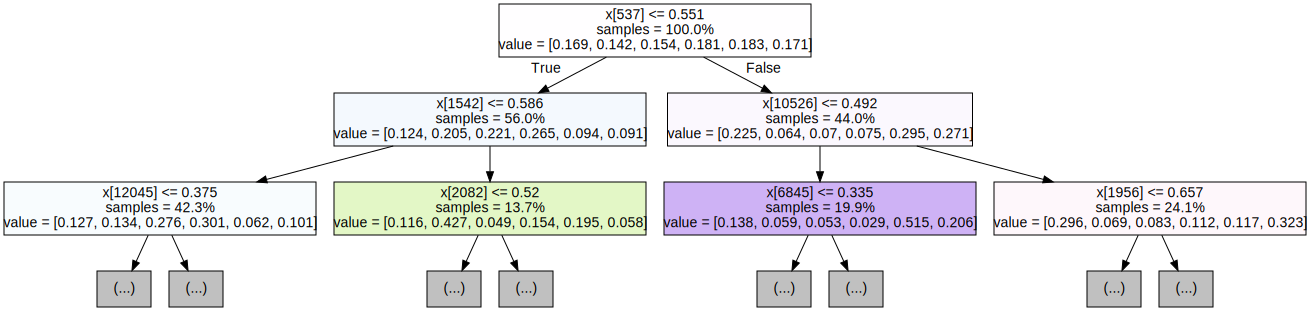

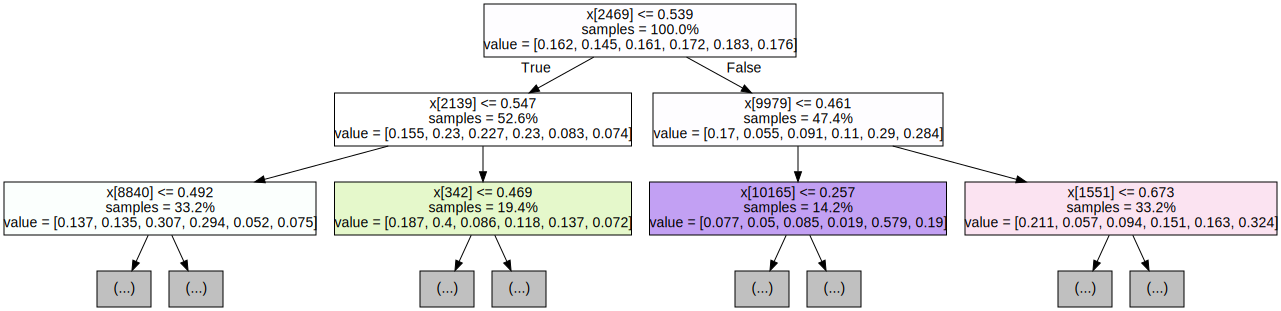

In [ ]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Export the first three decision trees from the forest
# Code adapted from: https://www.datacamp.com/tutorial/random-forests-classifier-python
for i in range(3):
    tree = clf2.estimators_[i]
    dot_data = export_graphviz(tree,
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)